# Phys 512: Homework 3

In [142]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import display
%matplotlib notebook

## Question 1: Diffusion Limit Aggregation

## a)

In [206]:
# Define relevant parameters
N = 10**4 # Number of particles
L = 200 # Length of grid

In [207]:
def RandomWalk(n):
    n = int(n)
    
    # initialize random particle position
    particle_position = np.random.randint(0, L, size=(N, 2))
    
    # create array to track positions at each timestep
    all_positions = np.zeros(shape=(N, 2, n))
    
    # create arrays to track net and rms displacement
    d_square = np.zeros(N)
    x_step = np.zeros(N)
    y_step = np.zeros(N)
    
    # iterate through number of timesteps
    for i in range(n):
        all_positions[:, :, i] = particle_position # track locations at timestep

        # update particle positions
        steps = np.random.randint(-1, 2, size=(N, 2)) # generate random steps in x and y for each particle
        particle_position += steps # apply steps
        particle_position %= L # apply periodic boundary conditions
        
        # track net and rms displacement at timestep
        d_square += (steps[:, 0]**2 + steps[:, 1]**2)
        x_step += steps[:, 0]
        y_step += steps[:, 1]
    
    # calculate final displacements
    d_rms = np.sqrt(d_square)
    d_total = np.sqrt(x_step**2 + y_step**2)
    
    return all_positions, d_rms, d_total

<IPython.core.display.Javascript object>


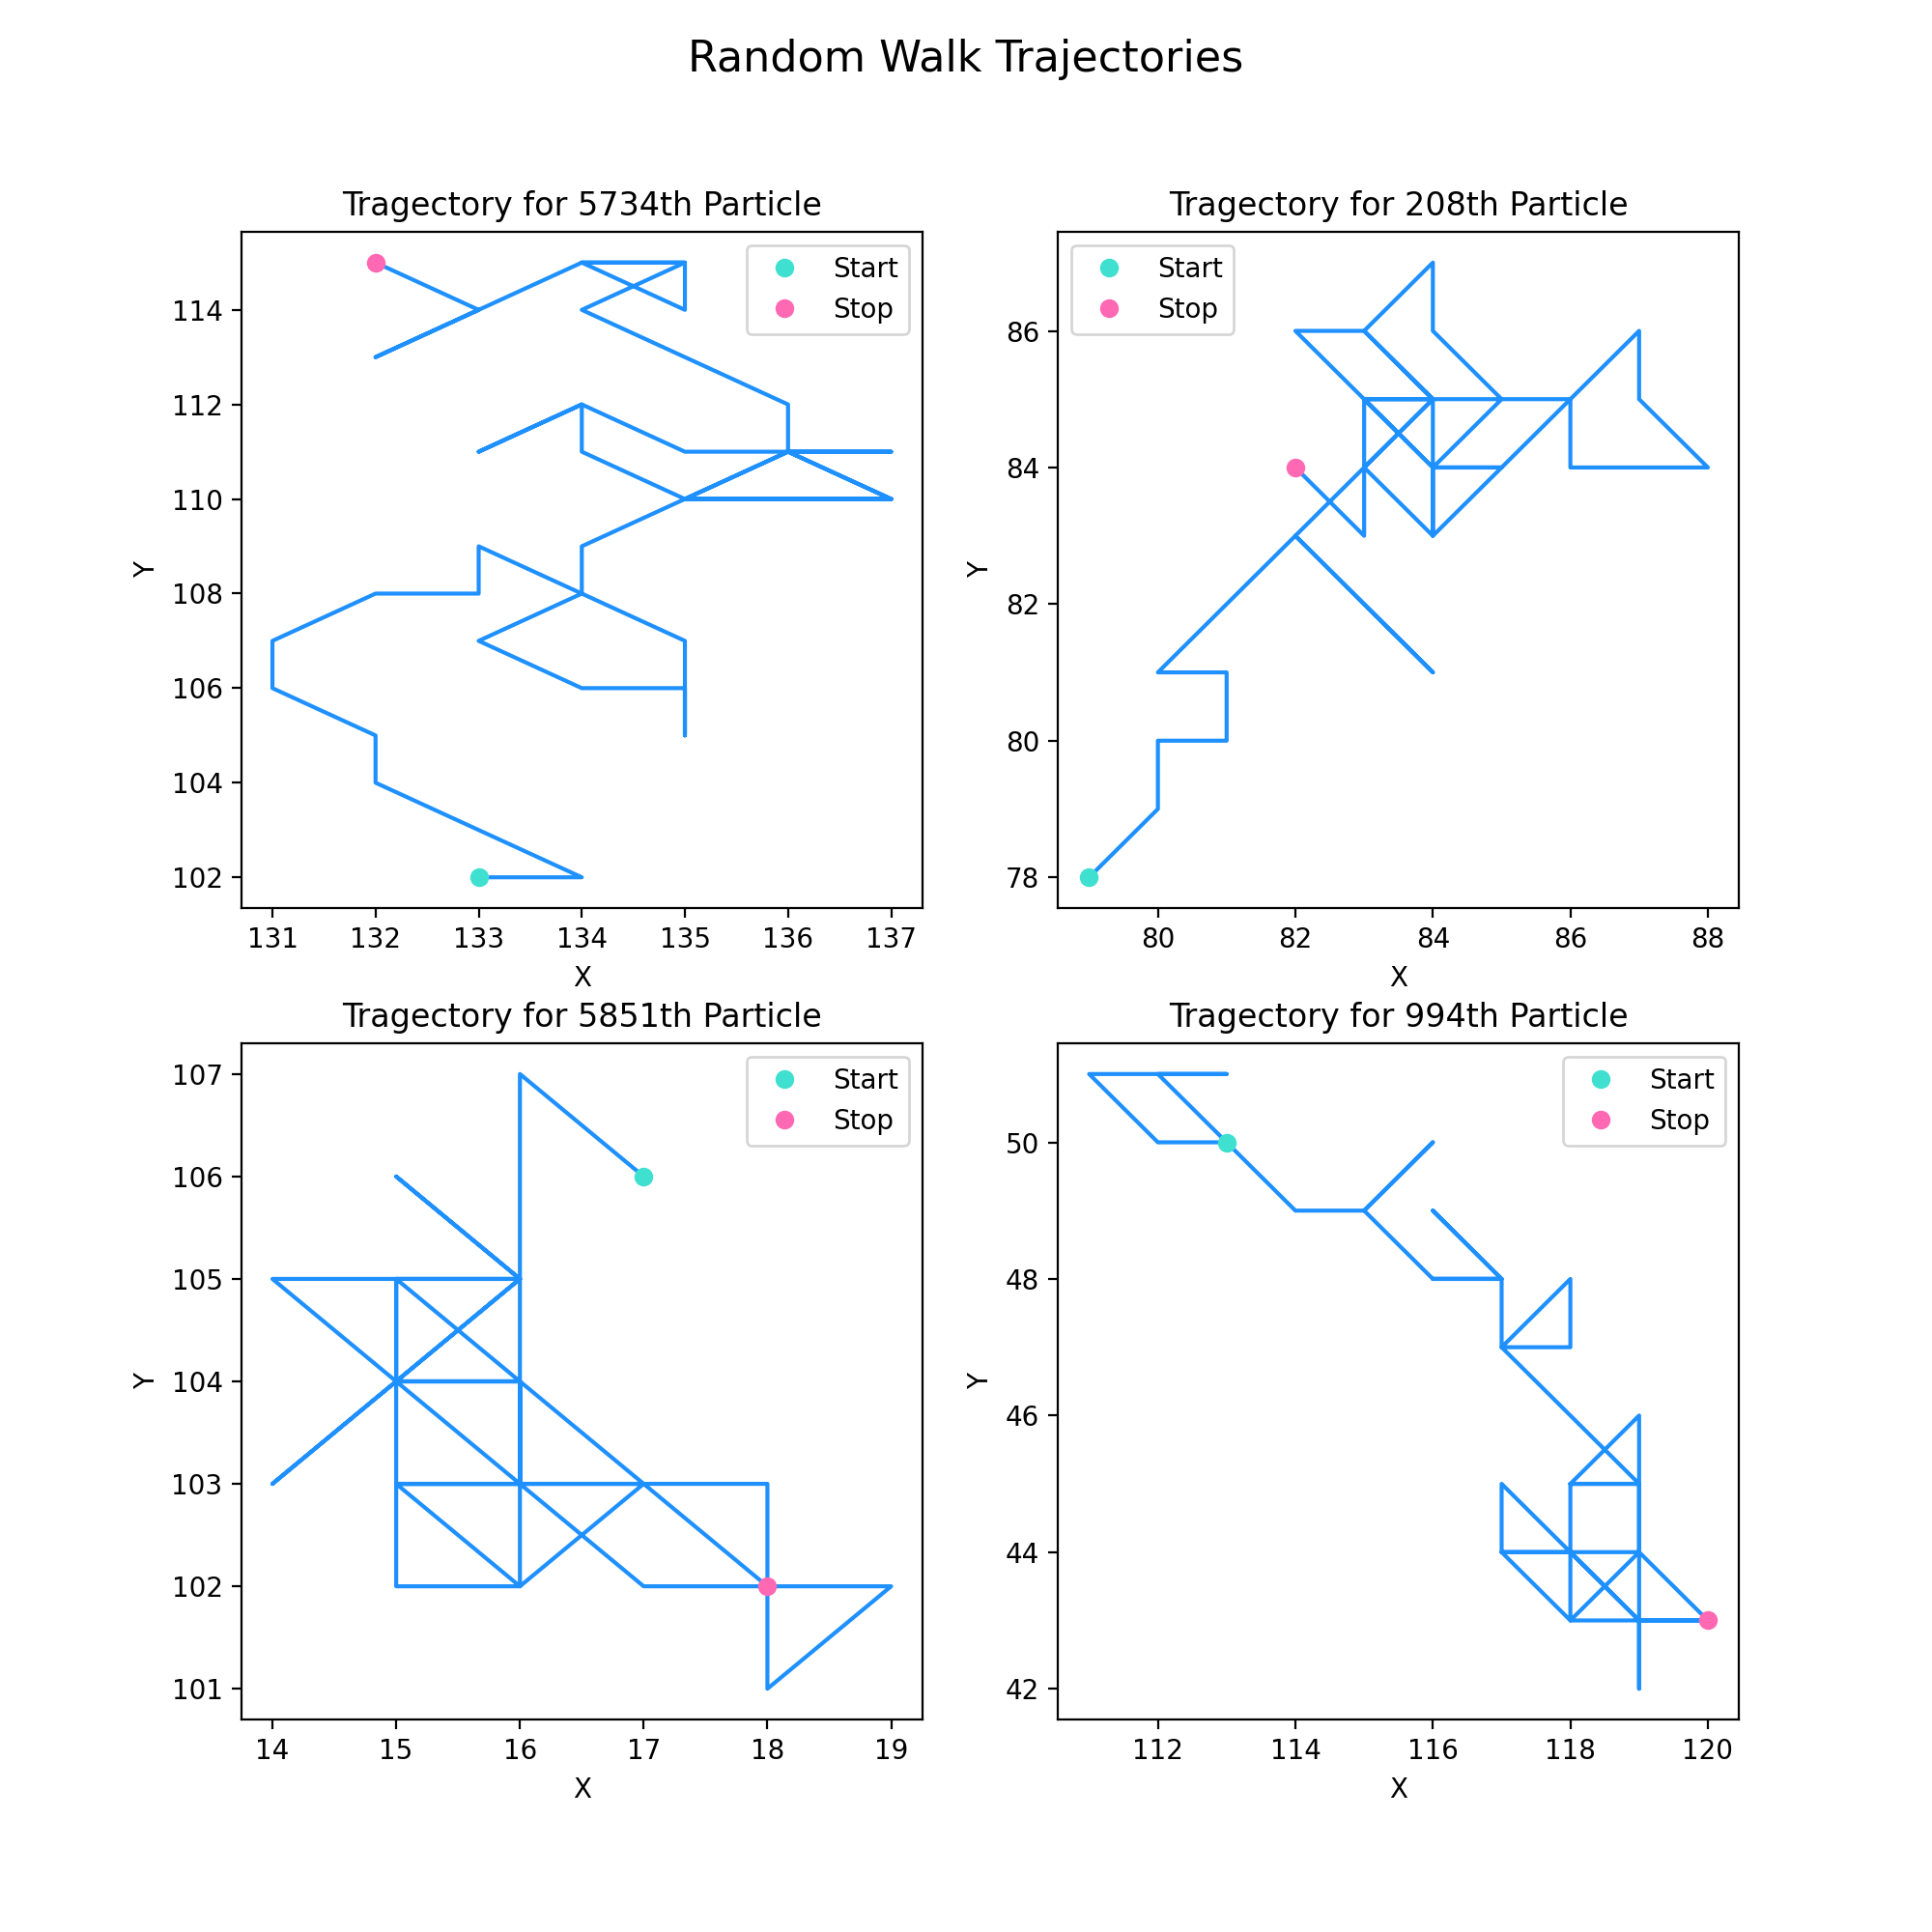

In [149]:
# perfom random walk simulation for 50 timesteps
walks, d_rms, d_tot = RandomWalk(50)

# randomly select 4 particles to plot
sample = np.random.randint(0, N, size=4)

# plot trajectories
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle('Random Walk Trajectories', fontsize=16)

for i, ax in enumerate(axes.flatten()):
    x, y = walks[sample[i]]    
    ax.set_title(f"Tragectory for %dth Particle" % sample[i])
    ax.plot(x, y, '-', color='dodgerblue')
    ax.plot(x[0], y[0], 'o', color='turquoise', label="Start")
    ax.plot(x[-1], y[-1], 'o', color='hotpink', label="Stop")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.legend()
plt.show()

<IPython.core.display.Javascript object>


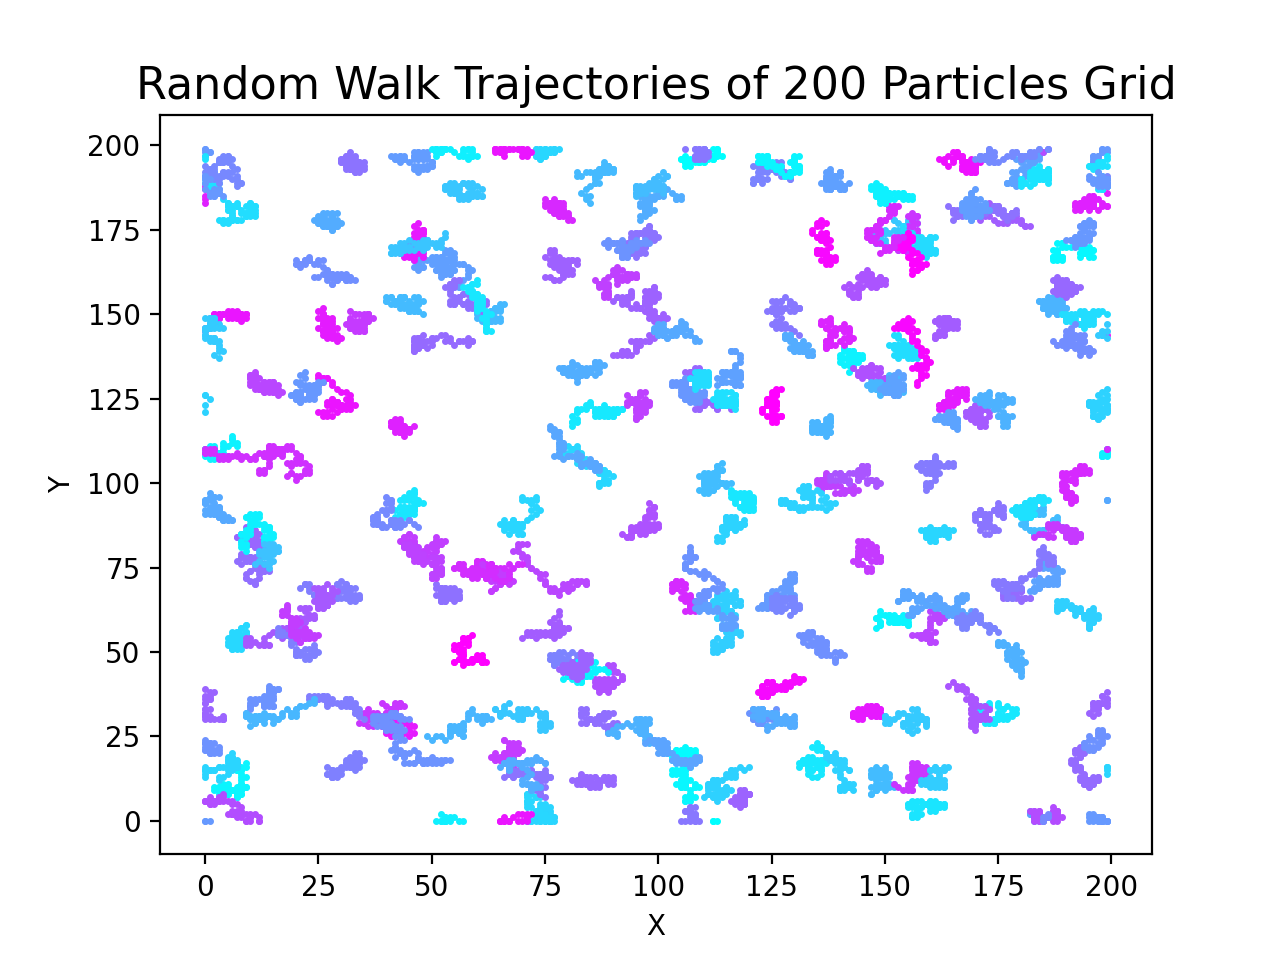

In [150]:
# now randomly select 200 particles to plot
sample = np.random.randint(0, N, size=200)

# plot trajectories of selected particles on grid
colors = plt.cm.cool(np.linspace(0, 1, N))

fig = plt.figure()
plt.title('Random Walk Trajectories of 200 Particles Grid', fontsize=16)

for s in sample:
    x, y = walks[s]     
    plt.plot(x, y, '.', ms=3, color=colors[s])
    
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [151]:
# perform random walk simulation for different numbers of timesteps and record net and rms displacement
n_values = np.linspace(10, 500, 50)
avg_rms_distance = np.zeros_like(n_values)
avg_total_distance = np.zeros_like(n_values)

for i in range(len(n_values)):
    walks, d_rms, d_tot = RandomWalk(n_values[i])
    avg_rms_distance[i] = np.mean(d_rms)
    avg_total_distance[i] = np.mean(d_tot)

<IPython.core.display.Javascript object>


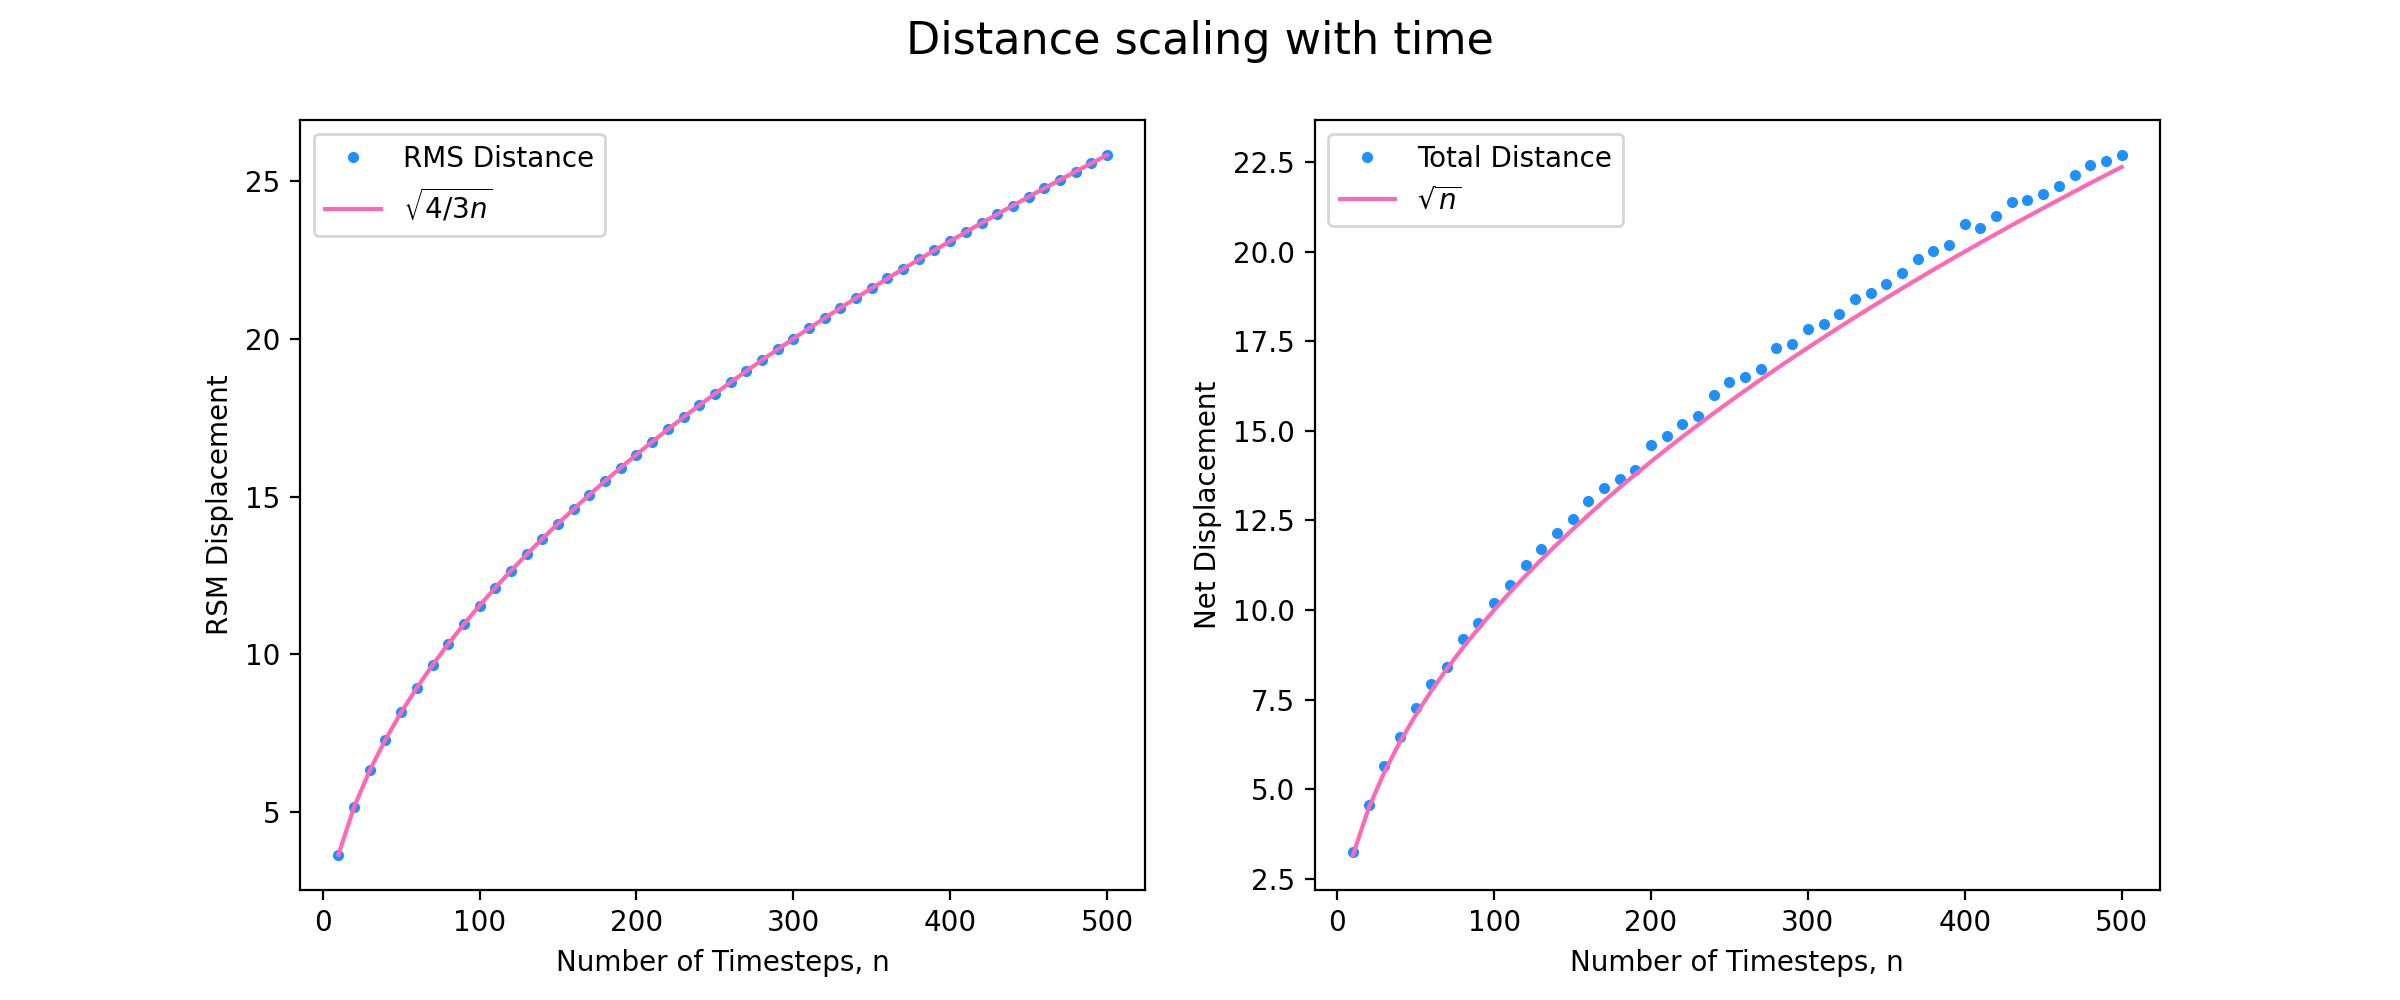

In [203]:
# plot distance vs number of timesteps
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Distance scaling with time', fontsize=16)

ax1.plot(n_values, avg_rms_distance, '.', label='RMS Distance', color='dodgerblue')
ax1.plot(n_values, np.sqrt(4/3 * n_values), label='$\sqrt{4/3 n}$', color='hotpink')
ax1.set_xlabel('Number of Timesteps, n')
ax1.set_ylabel('RSM Displacement')
ax1.legend()

ax2.plot(n_values, avg_total_distance, '.', label='Total Distance', color='dodgerblue')
ax2.plot(n_values, np.sqrt(n_values), label='$\sqrt{n}$', color='hotpink')
ax2.set_xlabel('Number of Timesteps, n')
ax2.set_ylabel('Net Displacement')

ax2.legend()

In a random walk we expect the displacement of any given particle to scale with the square root of the number of steps:

$d \propto \sqrt{n}$. 

This is what is observed in the plots above. The scaling factor of the rms distance can be calculated by averaging over all possible values of $d^2$ per timestep.

$d^2_{avg} = {1\over9} * 0 + {4\over9} * 1 + {4\over9} * 2 = {4\over3}$

Therefore:

$d_{rms} = \sqrt{n * d^2_{avg}} = \sqrt{{4\over3}n}$

This is exactly what we observe. The net displacement scales in the same way; however, the scaling factor is smaller since positive and negative steps might cancel between timesteps. This scaling is the result of the distribution of steps in random walks. The average of all steps is zero since the particle is just as likely to move up/right as it is to move down/left. However, the spread of this distribution increases by a factor of $\sqrt{n}$ for each step. 

## b)

In [209]:
# define function to update 2D distribution of liquid and solid particles at each timestep

def Update(frame):
    
    # allow variables to be updated within the funcition
    global grid, particle_position, is_liquid
    
    # terminate animation when 80% of particles are solid
    if (len(particle_position[~is_liquid]) / N) > 0.8:
        ani.event_source.stop()
    
    # update liquid particle positions with random steps
    steps = np.random.randint(-1, 2, size=(np.shape(particle_position[is_liquid])))
    particle_position[is_liquid] += steps
    particle_position[is_liquid] %= L

    # iterate through particles
    for p in range(len(particle_position)):

        x, y = particle_position[p]

        # check if liquid particles are in contact with crystal and if so change state
        if  is_liquid[p] and np.any(grid[(y - 1):(y + 2), (x - 1):(x + 2)]):

            grid[y, x] = True
            is_liquid[p] = False

    # update grid data
    solid.set_data(grid)

    # update positions sampled particles
    liquid_positions = particle_position[sample]
    liquid.set_offsets(liquid_positions)
    
    # update timestamp
    timestamp_text.set_text(f'Step Count: {frame}')
    
    return solid, liquid_positions, timestamp_text

<IPython.core.display.Javascript object>


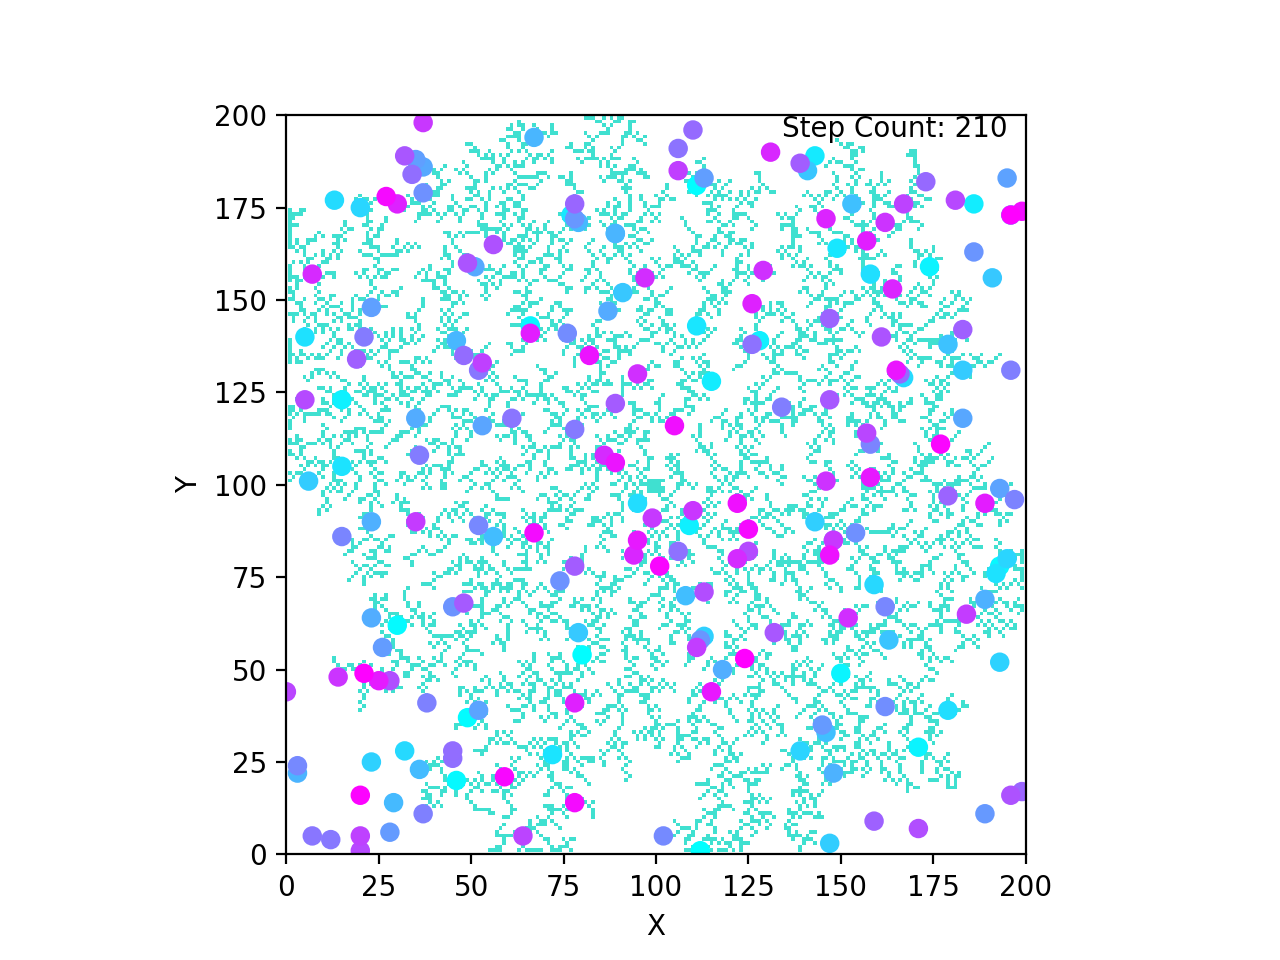

In [210]:
# Use Update function to crease animation

# create grid to track solid particles
grid = np.zeros(shape=(L, L))
    
# add seed to grid
seed_size = 4
grid[(L-seed_size)//2:(L+seed_size)//2, (L-seed_size)//2:(L+seed_size)//2] = True

# initialize random particle position
particle_position = np.random.randint(0, L, size=(N, 2), dtype=np.int64)

# create array to track indices of liquid/solid particles
is_liquid = np.full(N, True, dtype=bool)

# randomly select 200 particle to show on animation
sample = np.random.randint(0, N, size=200)
liquid_positions = particle_position[sample]

# plot animation
cmap = plt.cm.colors.ListedColormap(['white', 'turquoise'])
colors = plt.cm.cool(np.linspace(0, 1, len(sample)))

fig, ax = plt.subplots()

solid = ax.imshow(grid, cmap=cmap, origin='lower', label='crystal')
liquid = ax.scatter(liquid_positions[:, 0], liquid_positions[:, 1], c =colors, label='particles')
timestamp_text = ax.text(0.67, 0.97, '', transform=ax.transAxes)

plt.xlim(0, 200)
plt.ylim(0, 200)
plt.xlabel('X')
plt.ylabel('Y')

ani = FuncAnimation(fig, Update, frames=range(1000), interval= 1, repeat=False)
plt.show()

## c)

In [155]:
# Define a function (similar to Update) to track crystal growth at each timestep

def CrystalGrowth(n):
    # create grid to track solid particles
    grid = np.zeros(shape=(L, L))

    # add seed to grid
    seed_size = 4
    grid[(L-seed_size)//2:(L+seed_size)//2, (L-seed_size)//2:(L+seed_size)//2] = True

    # initialize random particle position
    particle_position = np.random.randint(0, L, size=(N, 2), dtype=np.int64)
    is_liquid = np.full(N, True, dtype=bool)
    
    # create array to track liquid/solid postions at each timestep
    all_positions = np.zeros(shape=(N, 2, n))
    all_solid_states = np.zeros(shape=(N, n))
    
   
    for i in range(n):
        
        all_positions[:, :, i] = particle_position # track particle positions at timestep
        all_solid_states[:, i] = ~is_liquid # track which particles are solid 
        
        # update liquid particle positions with random steps
        steps = np.random.randint(-1, 2, size=(np.shape(particle_position[is_liquid])))
        particle_position[is_liquid] += steps
        particle_position[is_liquid] %= L

        # iterate through particles
        for p in range(len(particle_position)):
            x, y = particle_position[p]
            
            # check if liquid particles are in contact with crystal and if so change state
            if  is_liquid[p] and np.any(grid[(y - 1):(y + 2), (x - 1):(x + 2)]):

                grid[y, x] = True
                is_liquid[p] = False
                

    return all_positions, all_solid_states

In [158]:
# run crystal growth simulation for 275 timesteps 
positions, solid_states = CrystalGrowth(275)

# calculate the number of solid particles at each timestep
N_solid = np.sum(solid_states, axis=0)

<IPython.core.display.Javascript object>


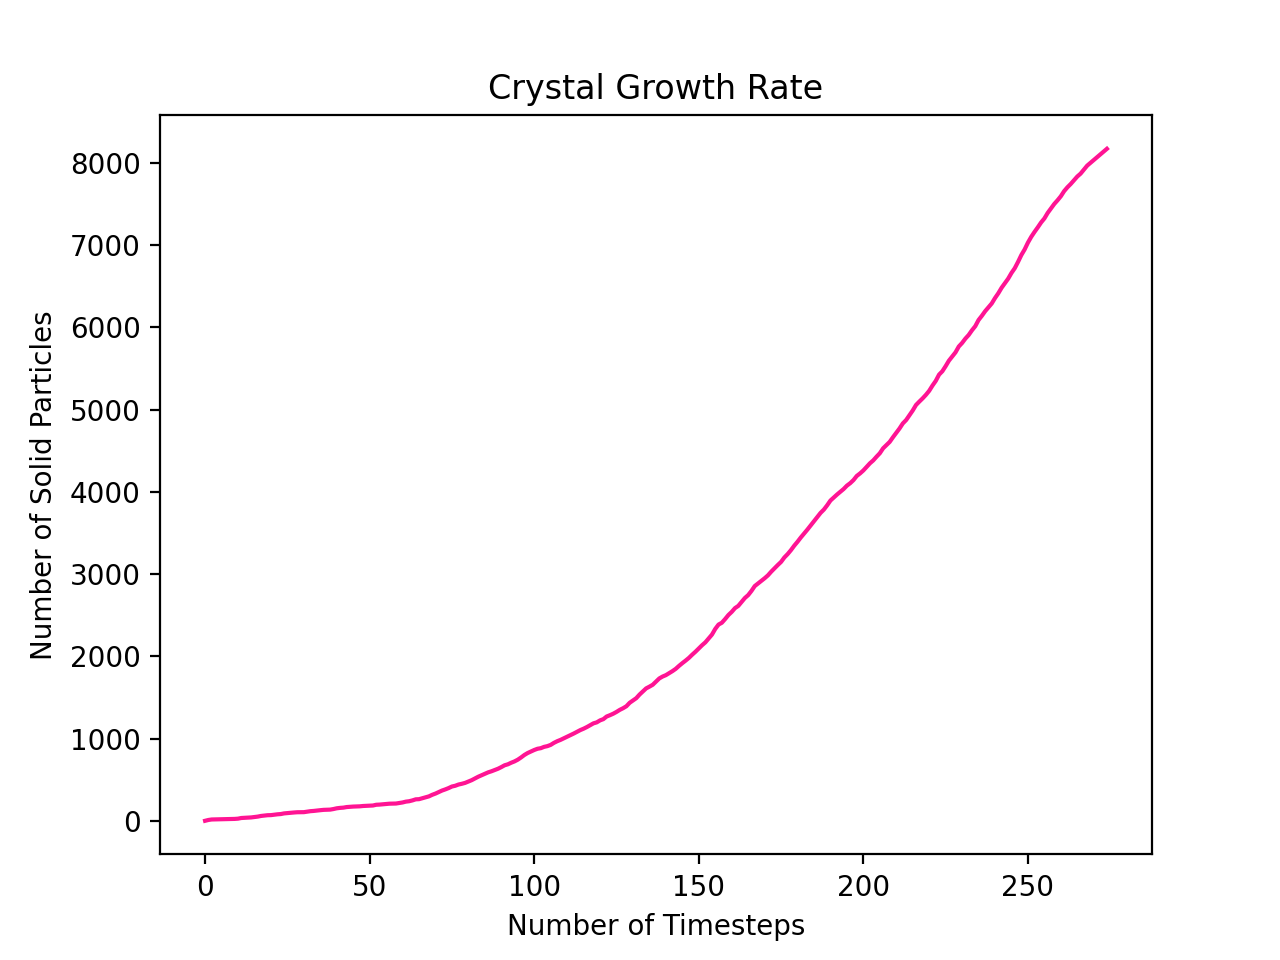

In [213]:
# plot number of solid particles vs number of timesteps

fig = plt.figure()
plt.title("Crystal Growth Rate")
plt.plot(N_solid, color='deeppink')
plt.xlabel('Number of Timesteps')
plt.ylabel('Number of Solid Particles')

plt.show()

For earlier timesteps (ie before the growth rate is limited by a lack of liquid particls) the growth rate of the crystal appears parabolic. 

$N_{solid} \propto n^2$

From a we know that the distance travelled by a particle undergoing a random work satisfies

$d \propto \sqrt{n}$.

This suggests

$N_{solid} \propto d^4$

The further a particle move, the more likely is is to interact with the crystal. In 2 dimensions, this explains a scaling of $d^2$. Furthermore, The larger the crystal, the more likely it is that a liquid particle interacts with it. This gives the second scaling of $d^2$.

# Question 2. Ising model

## a)

In the Metropolis Hastings algorithm a proposed step is accepted if ${f(x')\over f(x)}$ > 1. If ${f(x')\over f(x)}$ < 1, the step is accepted with a probability of ${f(x')\over f(x)}$.

In the Ising model:

$f(E) \propto e^{-E/k_b T}$

Therefore:

$\alpha = {f(E')\over f(E)} = e^{-(E'-E)/k_b T} = e^{-(\Delta E)/k_b T}$.

For $\Delta E$ < 0: $\alpha$ > 1 and the step is accepted.

For $\Delta E$ < 0: $\alpha$ < 1 and the step is accepted with a probability of $e^{-(\Delta E)/k_b T}$.

In [215]:
# define a function to create an grid of initial spins
# bias the spins to that 60% of dipoles are spin up so that simulations evolve in predictable ways

def CreateGrid(N):
    grid = np.zeros(shape=(N, N))
    uniform_grid = np.random.rand(N, N)
    grid[uniform_grid>0.6] = -1
    grid[uniform_grid<=0.6] = 1
    return grid

In [216]:
# define function to perform Metropolis-Hastings Algorithm 
def MetropolisHastings(step_count, kT, initial_spins):
    step_count = int(step_count)
    
    # create array to track the magnitization at each timestep
    M = np.zeros(step_count)
    
    # create copy of initial spin grid to update at each iteration
    spins = initial_spins.copy()
    
    for s in range(step_count):
        
        # generate cordinate of a random dipole to propose changing
        i = np.random.randint(0, N-1)
        j = np.random.randint(0, N-1)
        
        # calculate the change in energy that would result in flipping this dipole
        delta_E = 2 * spins[i, j] * (spins[(i+1)%N, j] + spins[(i-1)%N, j] + spins[i, (j+1)%N] + spins[i, (j-1)%N])

        # flip dipole according to the boltzmann probablility distrabution
        if delta_E <= 0 or np.random.rand()<=np.exp(-delta_E/kT):
            spins[i, j] *= -1

        # record magnitization at timestep
        M[s] = np.mean(spins)
        
    return M

## b)

In [214]:
# create a grid of 50x50 dipoles
N = 50
spin_grid = CreateGrid(N)

# define range of temp values in terms of kb * T
kT = np.linspace(1, 4, 4)

<IPython.core.display.Javascript object>


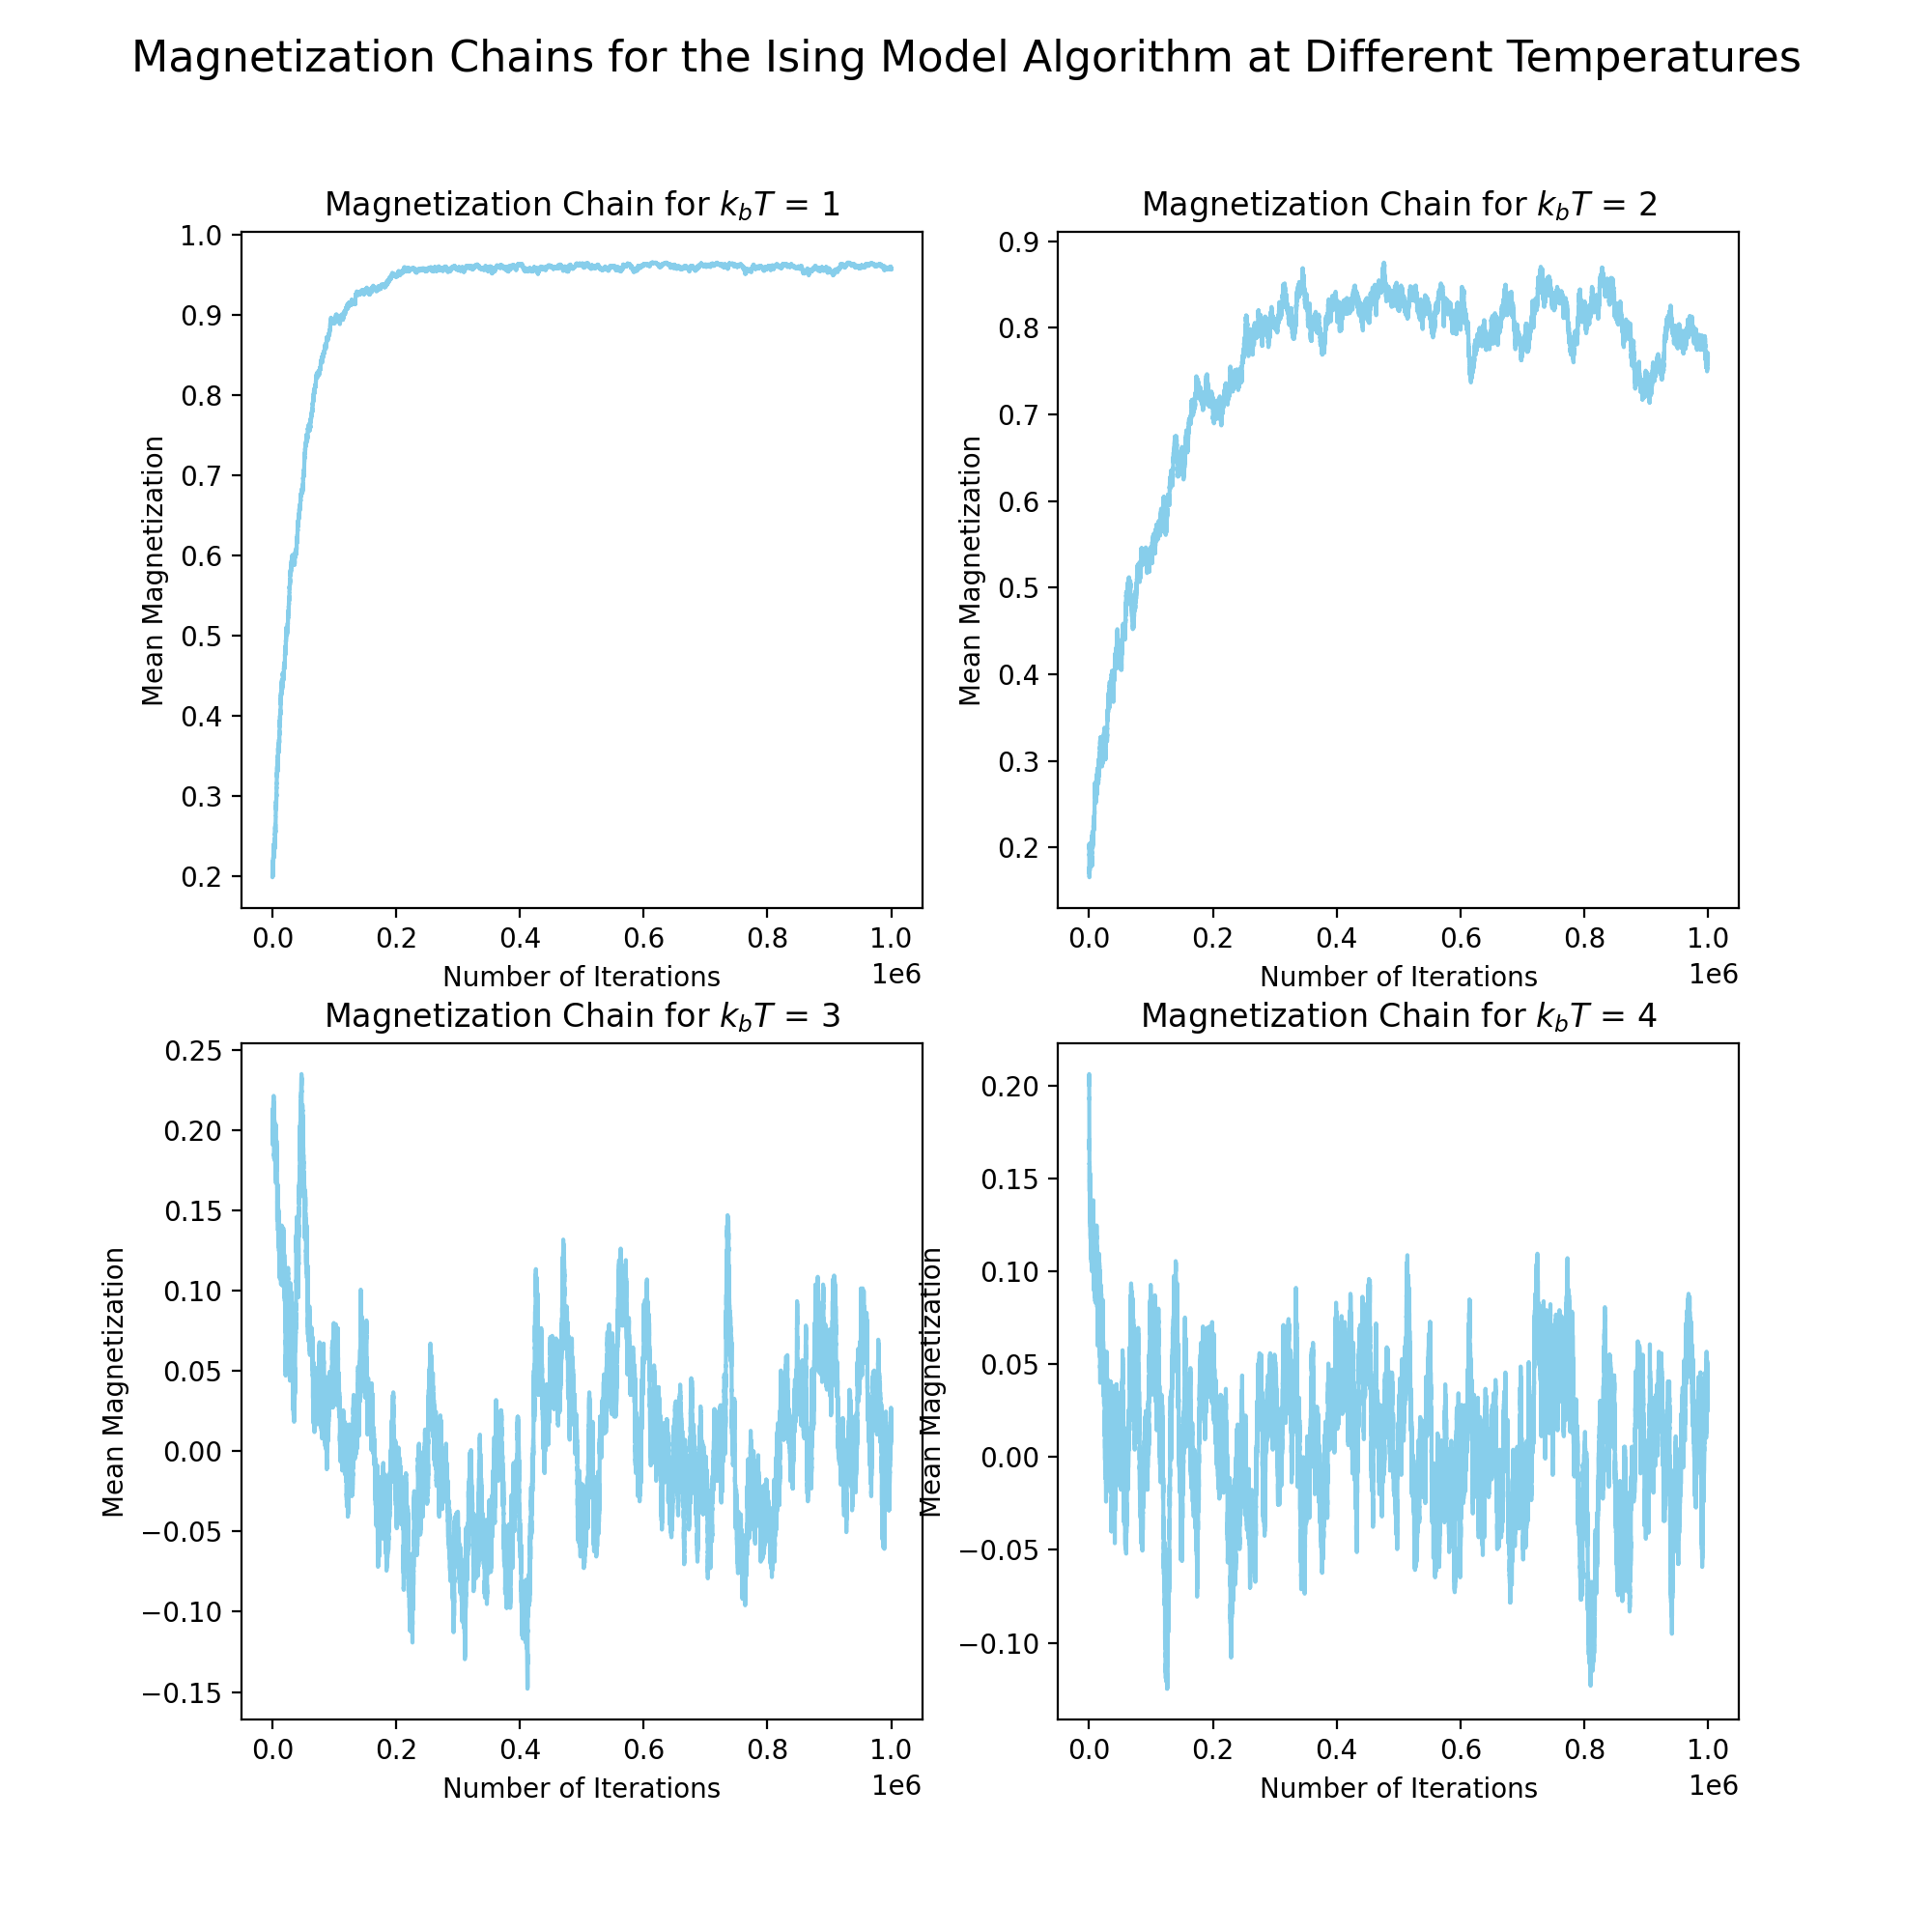

In [83]:
# plot magetization chain for each tempertature value

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle('Magnetization Chains for the Ising Model Algorithm at Different Temperatures', fontsize=16)

for i, ax in enumerate(axes.flatten()):
    M = MetropolisHastings((1e6), kT[i], spin_grid)
    ax.set_title(f"Magnetization Chain for $k_bT$ = %d" % kT[i])
    ax.plot(M, '-', ms=0.5, color="skyblue")
    ax.set_xlabel("Number of Iterations")
    ax.set_ylabel("Mean Magnetization")
plt.show()

At low temperatures, the dipoles align such that they each have +1 spin. The average magnetization therefore stabalizes quickly at 1. As the temperature increases, the dipoles do not align. Instead the average magnetization drops to approximately 0 (half up and half down). This change in behaviour or 'burn in' phase happens between $k_bT$ = 2 and $k_bT$ = 3. Note that here when I refer to average or mean magnitization, I mean the mean spin of all dipoles or the average magnetization per dipole. 

## c)

In [219]:
# define range of temp values in terms of kb * T
kT = np.linspace(1, 5, 20)

# create arrays to track mean magnitization and variance
mean_mag = np.zeros(20)
var_mag = np.zeros(20)

# for each temp value run Metropolis Hastings algorithm for 10^6 steps 
for i in range(len(kT)):
    m = MetropolisHastings((1e6), kT[i], spin_grid)
    mean_mag[i] = np.mean(m[-200000:]) # take the mean of the magnetazation for the final fifth of timesteps
    var_mag[i] = np.var(m[-2000000:]) # take the varience of the magnetazation for the final tenth of timesteps

<IPython.core.display.Javascript object>


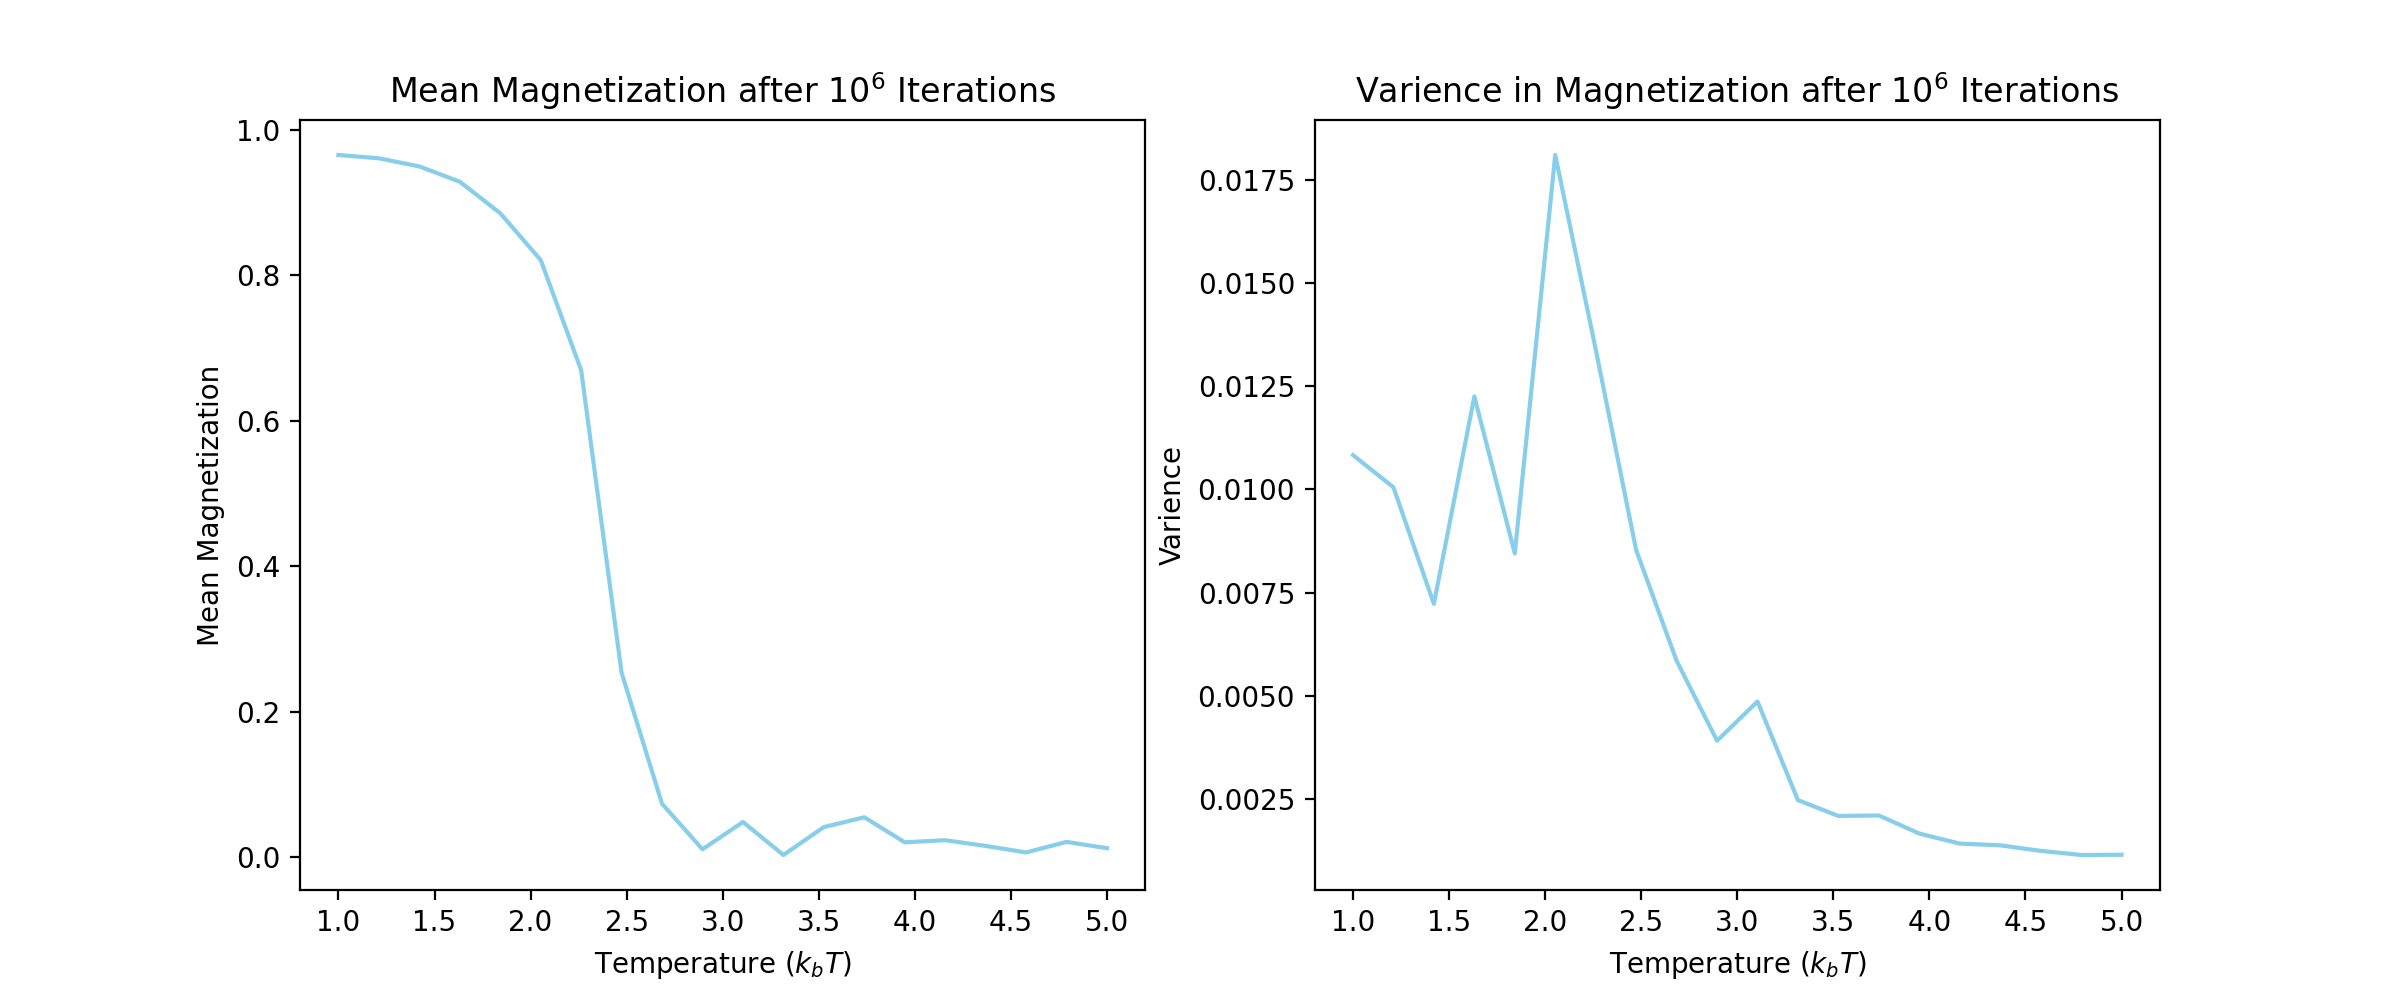

In [222]:
# plot figures
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(kT, mean_mag, '-', color='skyblue')
ax1.set_title("Mean Magnetization after $10^6$ Iterations")
ax1.set_xlabel('Temperature ($k_bT$)')
ax1.set_ylabel('Mean Magnetization')

ax2.plot(kT, var_mag, '-', color='skyblue')
ax2.set_title("Varience in Magnetization after $10^6$ Iterations")
ax2.set_xlabel('Temperature ($k_bT$)')
ax2.set_ylabel('Varience')

plt.show()

The mean magnitization at low temperatures is near one. It then drops to 0 for larger temperature values. This is consistent with the results from b). The varience in magnetization spikes near $k_bT = 2$. This is also where the phase transition occurs. Magnitazation therefore fluctuates most at this 'burn-in' temperature, as is expected. 